In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from tifffile import imread
from skimage.util.dtype import img_as_float
from skimage.color import gray2rgb

In [2]:
tissue = '840063_0110'
vmin = 700
vmax = 65535

In [3]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [4]:
save_dir = '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/bright_nuclei'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

data = pd.read_parquet(
    '/Users/greg/Dropbox (HMS)/topacio/cylinter_output/TOPACIO_FINAL/' +
    'output_orig/checkpoints/aggregateData.parquet')

dna = imread(f'/Volumes/T7 Shield/cylinter_input/TOPACIO_FINAL/tif/{tissue}.ome.tif', key=0)

# crop small
ymin_s = 12725
ymax_s = 12875
xmin_s = 18295
xmax_s = 18445

dna_crop_s = dna[ymin_s:ymax_s, xmin_s:xmax_s]

# isolate data for cells within small crop bounds
data_crop_s = data[['Y_centroid', 'X_centroid', 'DNA0']][
    (data['Sample'] == tissue) &
    (data['X_centroid'].between(xmin_s, xmax_s, inclusive='both')) &
    (data['Y_centroid'].between(ymin_s, ymax_s, inclusive='both'))
    ]

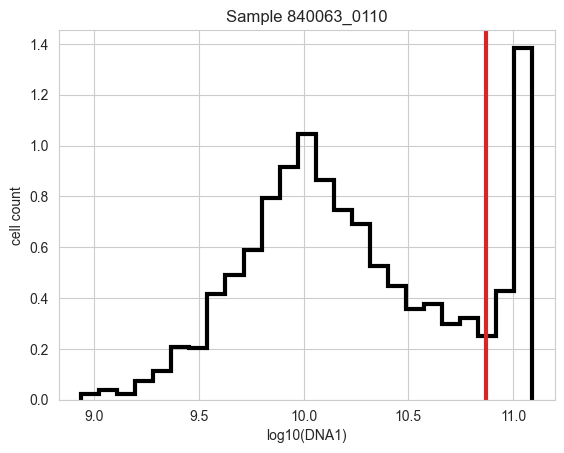

In [5]:
# crop large
ymin_l = 12700
ymax_l = 13250
xmin_l = 17950
xmax_l = 18625
dna_crop_l = dna[ymin_l:ymax_l, xmin_l:xmax_l]

# isolate data for cells within large crop bounds
data_crop_l = data[['Y_centroid', 'X_centroid', 'DNA0']][
    (data['Sample'] == tissue) &
    (data['X_centroid'].between(xmin_l, xmax_l, inclusive='both')) &
    (data['Y_centroid'].between(ymin_l, ymax_l, inclusive='both'))
    ]

gate = (10.87, np.log(data_crop_l['DNA0']).max())

sns.set_style('whitegrid')
plt.hist(np.log(data_crop_l['DNA0']), bins=25, color='k', density=True, histtype='step', lw=3.0)
plt.axvline(gate[0], c='tab:red', lw=3.0)
plt.title(f'Sample {tissue}')
plt.xlabel('log10(DNA1)')
plt.ylabel('cell count')
plt.savefig(os.path.join(save_dir, 'gated_hist.pdf'))
plt.show()
plt.close('all')

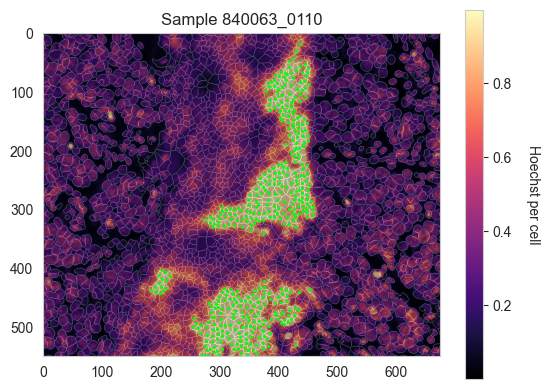

In [6]:
# plot large image
blank = np.zeros((dna_crop_l.shape[0], dna_crop_l.shape[1]))
blank = gray2rgb(blank)

dna_crop_l = img_as_float(dna_crop_l)
dna_crop_l = np.clip(dna_crop_l, 0, dna_crop_l.max())
dna_crop_l = (dna_crop_l - np.min(dna_crop_l))/np.ptp(dna_crop_l)

dna_crop_l_rgb = plt.cm.magma(dna_crop_l) # converts to RGBA automatically
dna_crop_l_rgb = dna_crop_l_rgb[:, :, 0:3]  # drop alpha dimension
dna_crop_l_rgb /= 1.5
blank += dna_crop_l_rgb

seg = imread(f'/Volumes/T7 Shield/cylinter_input/TOPACIO_FINAL/seg/{tissue}.ome.tif', key=0)
seg_crop_l = seg[ymin_l:ymax_l, xmin_l:xmax_l]
seg_crop_l = img_as_float(seg_crop_l)
seg_crop_l_rgb = gray2rgb(seg_crop_l)
seg_crop_l_rgb = seg_crop_l_rgb * (0.5, 0.5, 0.5)
seg_crop_l_rgb /= 1.5
blank += seg_crop_l_rgb

gated_centroids = data_crop_l[['Y_centroid', 'X_centroid']][
    (np.log(data_crop_l['DNA0']).between(gate[0], gate[1], inclusive='both'))
    ]

# transform x, y coordinates of gated cells within ROI bounds
gated_centroids['X_centroid'] = data_crop_l['X_centroid']-xmin_l
gated_centroids['Y_centroid'] = data_crop_l['Y_centroid']-ymin_l

plt.imshow(blank, cmap='magma')
plt.grid(False)
cbar = plt.colorbar()
# cbar = plt.colorbar(format=ticker.FuncFormatter(fmt))
cbar.set_alpha(1.0)
cbar.set_label('Hoechst per cell', labelpad=20, rotation=270)
cbar.draw_all()

# overlay cell centorids
plt.scatter(
    gated_centroids['X_centroid'],
    gated_centroids['Y_centroid'], s=4.5, lw=0.0, color='lime'
    )
plt.title(f'Sample {tissue}')
plt.savefig(os.path.join(save_dir, 'bright_nuclei_large.png'), dpi=1000)

# save as a pdf, too
plt.savefig(os.path.join(save_dir, 'bright_nuclei_large.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


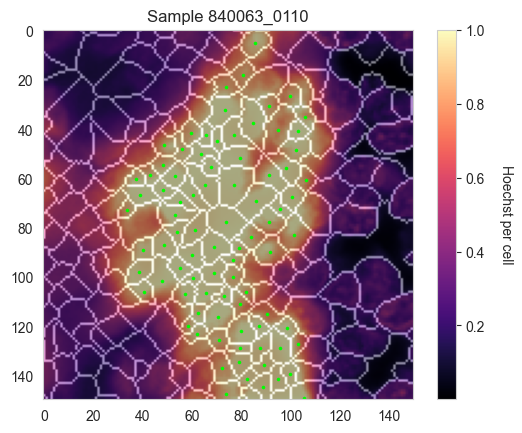

In [7]:
# plot small image
blank = np.zeros((dna_crop_s.shape[0], dna_crop_s.shape[1]))
blank = gray2rgb(blank)

dna_crop_s = img_as_float(dna_crop_s)
dna_crop_s = np.clip(dna_crop_s, 0, dna_crop_s.max())
dna_crop_s = (dna_crop_s - np.min(dna_crop_s))/np.ptp(dna_crop_s)

dna_crop_s_rgb = plt.cm.magma(dna_crop_s) # converts to RGBA automatically
dna_crop_s_rgb = dna_crop_s_rgb[:, :, 0:3]  # drop alpha dimension
dna_crop_s_rgb /= 1.5
blank += dna_crop_s_rgb

seg = imread(f'/Volumes/T7 Shield/cylinter_input/TOPACIO_FINAL/seg/{tissue}.ome.tif', key=0)
seg_crop_s = seg[ymin_s:ymax_s, xmin_s:xmax_s]
seg_crop_s = img_as_float(seg_crop_s)
seg_crop_s_rgb = gray2rgb(seg_crop_s)
seg_crop_s_rgb *= 0.5
blank += seg_crop_s_rgb

gated_centroids = data_crop_s[['Y_centroid', 'X_centroid']][
    (np.log(data_crop_s['DNA0']).between(gate[0], gate[1], inclusive='both'))
    ]

# transform x, y coordinates of gated cells within ROI bounds
gated_centroids['X_centroid'] = data_crop_s['X_centroid']-xmin_s
gated_centroids['Y_centroid'] = data_crop_s['Y_centroid']-ymin_s

plt.imshow(blank, cmap='magma')
plt.grid(False)
cbar = plt.colorbar()
# cbar = plt.colorbar(format=ticker.FuncFormatter(fmt))
cbar.set_alpha(1.0)
cbar.set_label('Hoechst per cell', labelpad=20, rotation=270)
cbar.draw_all()

# overlay cell centorids
plt.scatter(
    gated_centroids['X_centroid'],
    gated_centroids['Y_centroid'], s=6.5, lw=0.0, color='lime'
    )
plt.title(f'Sample {tissue}')
plt.savefig(os.path.join(save_dir, 'bright_nuclei_small.png'), dpi=1000)

# save as a pdf, too
plt.savefig(os.path.join(save_dir, 'bright_nuclei_small.pdf'))
plt.show()
plt.close('all')